# Регрессия 3 - больше интересного!

> 🚀 В этой практике нам понадобятся: `numpy==1.26.4, pandas==2.2.2, matplotlib==3.8.4, scikit-learn==1.4.2` 

> 🚀 Установить вы их можете с помощью команды: `%pip install numpy==1.26.4 pandas==2.2.2 matplotlib==3.8.4 scikit-learn==1.4.2` 


## Содержание

* [Регуляризация](#Регуляризация)
* [Ещё немного о весах](#Ещё-немного-о-весах)
* [Другие методы оценки ошибки](#Другие-методы-оценки-ошибки)
* [Вопросы для закрепления](#Вопросы-для-закрепления)
* [Вопросы для расширения знаний](#Вопросы-для-расширения-знаний)
* [Полезные ссылки](#Полезные-ссылки)


Привет! Вы уже познакомились с новыми интересностями, которые происходят в результате обучения. Сегодня мы ещё немного уделим внимание работе с ситуацией, когда у нас произошел оверфит. Ещё мы посмотрим на пару других интересных метрик... Короче, продолжаем пополнять наш арсенал!

In [134]:
# Настройки для визуализации
# Если используется темная тема - лучше текст сделать белым
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
TEXT_COLOR = "black"

plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["text.color"] = TEXT_COLOR
plt.rcParams["font.size"] = 14
plt.rcParams["lines.markersize"] = 15
plt.rcParams["axes.labelcolor"] = TEXT_COLOR
plt.rcParams["xtick.color"] = TEXT_COLOR
plt.rcParams["ytick.color"] = TEXT_COLOR

# Зафиксируем состояние случайных чисел
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

## Регуляризация

Ранее мы уже посмотрели, как можно справиться с переобучением, помните? 

Одно из решений - увеличить выборку данных, собрать новых данных! 

Но так как мы не всегда можем это сделать, рассмотрим один из способов борьбы с помощью регуляризации.

Вернёмся к нашей ситуации с оверфитом и посмотрим на то, что у нас происходит чуть глубже:

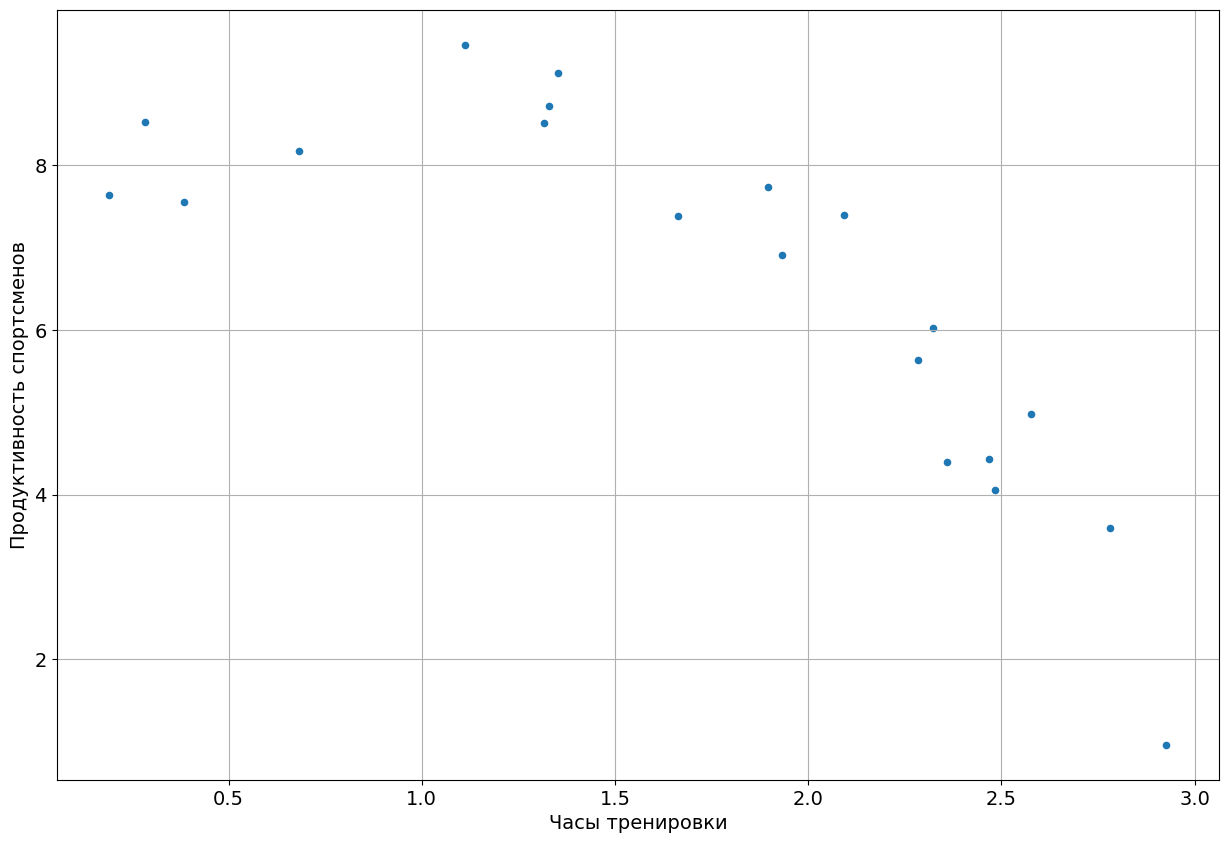

In [138]:
rng = np.random.default_rng(RANDOM_SEED)

_x_data = 3*rng.random(20)
_y_data = 7 + 4*_x_data + -2*_x_data**2 + 2*(rng.random(_x_data.shape[0])-0.5)

df_data = pd.DataFrame({"hours": _x_data, "productivity": _y_data})

plt.scatter(x="hours", y="productivity", data=df_data, s=20)
plt.xlabel("Часы тренировки")
plt.ylabel("Продуктивность спортсменов")
plt.grid()

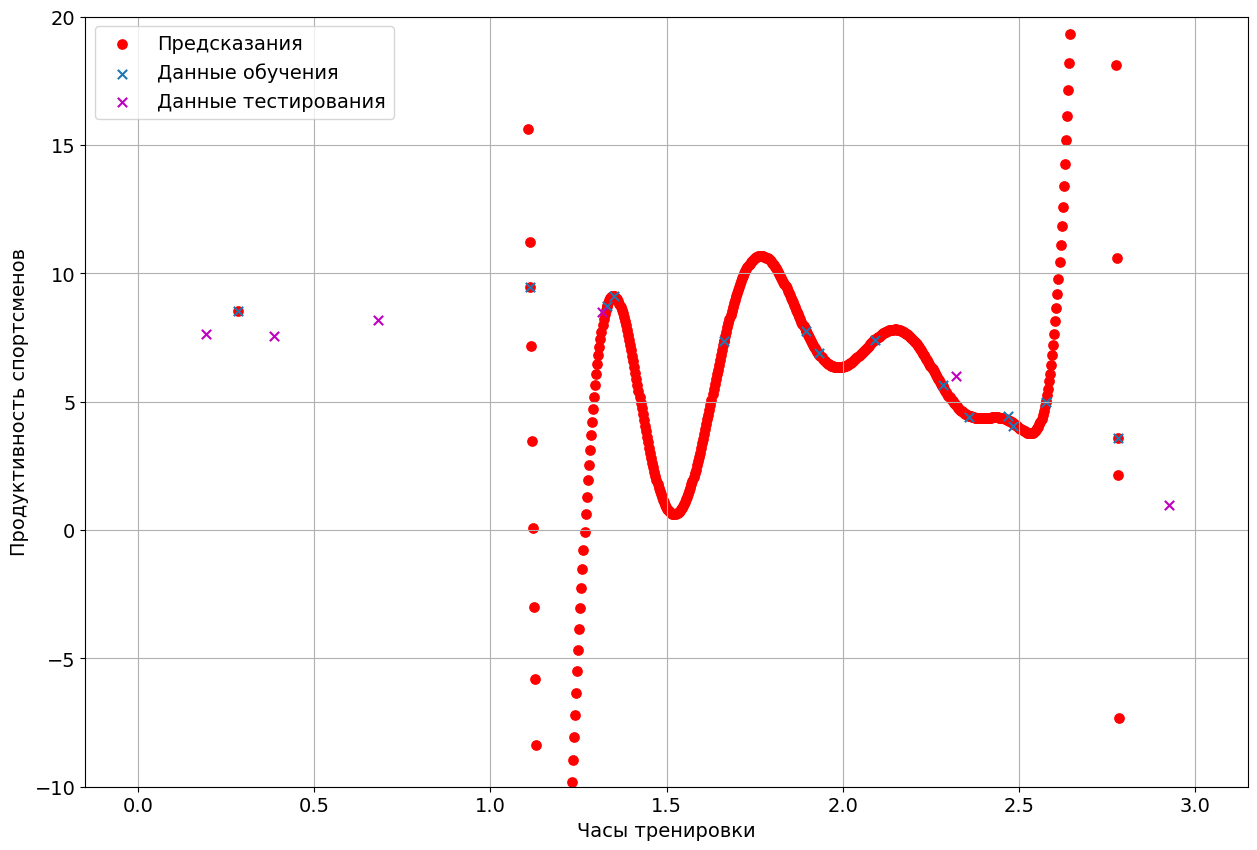

In [140]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

def preprocess_data_poly(df, max_power):
    for power in range(max_power): 
        df[f"hours_poly_{power}"] = df["hours"]**power
    return df

df_train_data, df_test_data = train_test_split(df_data, test_size=.3, random_state=RANDOM_SEED, shuffle=True)

reg_model = LinearRegression()

df_x = df_train_data.copy()
df_x = preprocess_data_poly(df_x, 15)

y_true = df_x.pop("productivity")
reg_model.fit(df_x, y_true)

x_render = np.concatenate([np.linspace(0, 3, 1000), df_x["hours"]])
df_line_data = pd.DataFrame({"hours": x_render})

df_line_data = preprocess_data_poly(df_line_data, 15)
y_pred_render = reg_model.predict(df_line_data)

plt.scatter(x_render, y_pred_render, c="r", s=45, label="Предсказания")
plt.scatter(x="hours", y="productivity", data=df_train_data, marker="x", s=45, label="Данные обучения")
plt.scatter(x="hours", y="productivity", data=df_test_data, c="m", marker="x", s=45, label="Данные тестирования")
plt.xlabel("Часы тренировки")
plt.ylabel("Продуктивность спортсменов")
plt.ylim([-10, 20])
plt.grid()
plt.legend()
plt.show()

In [148]:
# TODO - напишите функцию evaluate_data()
#   функция должна принимать DataFrame с данными для оценки и объект модели
#   функция должна возвращать dict с ключами:
#   - mae_score
#   - r2_score
from sklearn.metrics import mean_absolute_error, r2_score

def evaluate_data(df, model):
    y_true = df["productivity"]
    df_x = preprocess_data_poly(df, 15)
    df_x = df_x.drop(columns=["productivity"])
    y_pred = model.predict(df_x)
    mae_score = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        "mae_score": mae_score,
        "r2_score": r2
    }



In [150]:
# TEST - проверимс ваше решение
_df_test = pd.DataFrame({
    "hours": [2.7, 0.3],
    "productivity": [2.5, 8]
})

_test_results = evaluate_data(_df_test, reg_model)

assert isinstance(_test_results, dict)
np.testing.assert_approx_equal(_test_results["mae_score"], 7923.98, significant=4)
np.testing.assert_approx_equal(_test_results["r2_score"], -16515683.42, significant=4)

print("Well done!")

Well done!


In [152]:
# Теперь проверим наши показатели на выборке обучения и тестирования
train_metrics = evaluate_data(df_train_data.copy(), reg_model)
test_metrics = evaluate_data(df_test_data.copy(), reg_model)

print(f"Train metrics: {train_metrics}")
print(f"Test metrics: {test_metrics}")

Train metrics: {'mae_score': 0.032383391958623865, 'r2_score': 0.9992302313279731}
Test metrics: {'mae_score': 38403.80320375813, 'r2_score': -641890998.6433604}


Отлично, мы видим явный оверфит по показателям, это же мы видели, когда нарисовали аналитическую кривую модели.

Давайте теперь посмотрим на веса модели:

In [155]:
weights = reg_model.coef_
bias = reg_model.intercept_

print(f"Model weights:\n{weights}\n")
print(f"Model bias:\n{bias}\n")
print(f"Weights min: {weights.min()}")
print(f"Weights max: {weights.max()}")

Model weights:
[ 4.31007762e+06  2.21558250e+01  4.22685034e+06 -2.28091521e+07
  2.52542800e+07 -1.93484939e+06 -2.20431751e+07  1.51102089e+07
  1.17002390e+07 -2.65243468e+07  2.14796651e+07 -1.02193672e+07
  3.09677067e+06 -5.91411818e+05  6.52566345e+04 -3.18411883e+03]

Model bias:
-1117295.2169282336

Weights min: -26524346.827895742
Weights max: 25254279.95432899


Смотрите, веса модели находятся в диапазоне от -200 тысяч до 230 тысяч!

Давайте вспомним, что уравнение модели линейной регресии: $$y = w_1*x_1 + w_2*x_2 + ... +w_{n}*x_{n} + w_0$$

Получается, что некоторые степени полинома имеют огромный вес! Это плохо, так как огромные веса у высоких степеней полиномов дают огромные значения!

Поэтому, мы попробуем применить метод, который старается уменьшить значения весов. Посмотрим, как это делается и что это дает!

> ⚠️ В работе с данными всегда старайтесь понимать, что у вас за данные, и что они означают. Это может сильно помочь в работе с ними, так как, например, замеры времени не могут быть отрицательными, чем вы можете пользоваться при обработке.

Для этого мы воспользуемся новым классом - [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html):

In [216]:
# TODO - напишите функцию генерации модели generate_ridge_model(),
# которая на вход принимает DataFrame для обучения и возвращает обученную модель
# Не забывайте, что надо использовать новый класс и в нём зафиксировать random_state!
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.datasets import make_regression
import numpy as np

# Определение функции для генерации модели Ridge
def generate_ridge_model(df):
    target_column = "productivity"  # Фиксируем имя целевой переменной
    
    # Выделяем признаки и целевую переменную
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Создаем и обучаем модель Ridge с фиксированным random_state
    ridge_model = Ridge(random_state=42)
    ridge_model.fit(X, y)
    
    return ridge_model




In [218]:
# TEST - проверимс ваше решение
from sklearn.datasets import make_regression

_x, _y = make_regression(n_features=1, random_state=RANDOM_SEED)

_test_df = pd.DataFrame({"hours": _x[:,0], "productivity": _y})
_test_model = generate_ridge_model(_test_df)

assert isinstance(_test_model, Ridge)
np.testing.assert_array_almost_equal(
    _test_model.coef_, 
    np.array([
        19.3212552, 0. , 19.3212552, -0.24977129, 3.98790634,
        0.36084778, 0.15580929, 0.26121287, -0.81115073, -0.13586637,
       -0.45484496, -0.21564543, 0.3776078 , 0.1394734, -0.05889839,
       -0.02147148]
    )
)

print("Well done!")

AssertionError: 
Arrays are not almost equal to 6 decimals

(shapes (1,), (16,) mismatch)
 x: array([41.236079])
 y: array([19.321255,  0.      , 19.321255, -0.249771,  3.987906,  0.360848,
        0.155809,  0.261213, -0.811151, -0.135866, -0.454845, -0.215645,
        0.377608,  0.139473, -0.058898, -0.021471])

In [220]:
# Теперь используем ее, чтобы обучить модель и посмотреть на линию модели

ridge_model = generate_ridge_model(df_train_data.copy())

x_render = np.linspace(0, 3, 1000)
df_line_data = pd.DataFrame({"hours": x_render})

df_line_data = preprocess_data_poly(df_line_data, 15)
y_pred_render = ridge_model.predict(df_line_data)

plt.scatter(x_render, y_pred_render, c="r", s=45, label="Предсказания")
plt.scatter(x="hours", y="productivity", data=df_train_data, marker="x", s=45, label="Данные обучения")
plt.scatter(x="hours", y="productivity", data=df_test_data, c="m", marker="x", s=45, label="Данные тестирования")
plt.xlabel("Часы тренировки")
plt.ylabel("Продуктивность спортсменов")
plt.ylim([-10, 20])
plt.grid()
plt.legend()
plt.show()

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- hours_poly_0
- hours_poly_1
- hours_poly_10
- hours_poly_11
- hours_poly_12
- ...


Глядите, линейная модель 15-й степени стала более стабильной! 

Да, есть небольшое возрастание в конце участка, но в целом применение модели Ридж помогло! 

Давайте теперь посмотрим на самое главное - веса модели!

In [223]:
weights = ridge_model.coef_
bias = ridge_model.intercept_

print(f"Model weights:\n{weights}\n")
print(f"Model bias:\n{bias}\n")
print(f"Weights min: {weights.min()}")
print(f"Weights max: {weights.max()}")

Model weights:
[-2.19586157]

Model bias:
10.77038914097765

Weights min: -2.1958615668865016
Weights max: -2.1958615668865016


Веса меньше варьируются! Теперь диапазон значений всего лишь в пределах [-0.1; 0.5]! 

Осталось убедиться, что и метрики стали адекватнее:

In [226]:
train_metrics = evaluate_data(df_train_data.copy(), ridge_model)
test_metrics = evaluate_data(df_test_data.copy(), ridge_model)

print(f"Train metrics: {train_metrics}")
print(f"Test metrics: {test_metrics}")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- hours_poly_0
- hours_poly_1
- hours_poly_10
- hours_poly_11
- hours_poly_12
- ...


Показатели на обучении всё ещё лучше, чем на тесте, но это уже огромный прогресс, так как теперь нет такой большой разницы между ошибкой на обучении и тесте! И вы сами видите, что линия модели на графике больше похожа на основную зависимость в данных.

Почему так получилось? 

Ридж регуляризация - один из способов регуляризации, который применяется для уменьшения разброса весов в модели. Сильный разброс весов может быть одним из следствий, по которому можно выявить оверфит, а Ридж работает так, что в ходе обучения веса стараются держаться близко к нулю, что, как видите, дает значительный результат!

По сути, при обучении модели линейной регресии мы стараемся минимизировать разницу между истинными значениями и предсказанными (MAE ведь это и измеряет, вот, например, её мы и пытаемся свести к минимум, как мы делали руками), но теперь с Ридж модификацией мы не только пытаемся ошибку свести к минимуму, но ещё и сумму весов модели держать возле нуля.

Раньше сумма абсолютных значений весов была такая:

In [229]:
np.sum(np.abs(reg_model.coef_)) + reg_model.intercept_

168251561.642566

А теперь стала такой:

In [232]:
np.sum(np.abs(ridge_model.coef_)) + ridge_model.intercept_

12.966250707864152

И вот, к чему это привело! Даже модель с полиномиальными данными 15-й степени почти не демонстрирует переобучения! Держите хороший инструмент в вашу копилку!

> ⚠️ Подход регуляризации применяется не только в обучении линейной регрессии, но и в нейросетях и в других моделях. Важно помнить, что это один из способов предотвратить переобучение модели, но не панацея. Даже с применением регуляризации любого типа важно анализировать результаты работы модели!

> ⚠️ На деле, Ридж регуляризация старается удерживать норму второго порядка вектора весов $\|w\|^2_2$ ближе к нулю. Если вам этот термин не понятен или вызывает вопросы, то обязательно обсудите это с преподавателем! Понятие нормы очень важно, так как используется в машинном обучении довольно часто!

## Ещё немного о весах

Мы сейчас затронули тему величины весов, но давайте задумаемся, что такое веса линейной модели?

По сути, ведь вес - это коэффициент того, насколько важен тот или иной признак. Взглянем на уравнение с двумя независимыми переменными: $$y = w_1*x_1 + w_2*x_2 + w_0$$

Если в результате обучения вес $w_1$ будет равен нулю, а $w_2$ нет, то получается, что $x_1$ не участвует в генерации $y$, а значит не важен.

То есть выходит, что на веса **линейных** моделей можно смотреть, как на коэффициенты значимости признаков.

Давайте теперь рассмотрим реальный пример, который поможет понять, почему важна такая операция, как **масштабирование признаков (feature scaling)**.

Например, возьмём такую модель:

$$
y = 2*x_1 + 20*x_2
$$

Без знания и описания данных, на которых обучена модель, можно лишь сказать, что признак $x_2$ в 10 раз важнее в формировании результата предсказания, нежели $x_1$.

Чтобы лучше представить ситуацию (кейс), приложим больше подробностей:
- зависимая переменная $y$ - количество баллов на экзамене $[0; 100]$;
- признак $x_1$ - количество выполненных заданий $[0; 40]$;
- признак $x_2$ - отношение количества посещений к количеству прошедших занятий $[0; 1]$.

Попробуем представить пример таких данных:

In [238]:
W = [2, 20]

rng = np.random.default_rng(RANDOM_SEED)

X = rng.uniform(low=0, high=[40, 1], size=(150, 2))
X[:, 0] = X[:, 0].astype(int)
y_true = np.clip(X.dot(W)+rng.standard_normal(150)*3, 0, 100)

df_edu = pd.DataFrame(X[:,:2], columns=["Заданий завершено", "Пропорция посещения занятий"])
df_edu["Оценка"] = y_true

df_edu.head(15)

,Заданий завершено,Пропорция посещения занятий,Оценка
0,30.0,0.438878,67.901055
1,34.0,0.697368,81.636896
2,3.0,0.975622,24.756515
3,30.0,0.786064,76.178974
4,5.0,0.450386,23.422195
5,14.0,0.926765,38.835324
6,25.0,0.822762,65.744681
7,17.0,0.227239,39.074312
8,22.0,0.063817,46.164327
9,33.0,0.631664,77.517544


Что можно отметить: студенты, которые почти не ходили на занятия, но выполнили большое количество заданий, получили высокую оценку. Обратная ситуация, были на всех занятиях, но при этом выполнили мало задач - никто не получил хорошей оценки (ведь оценка отражает знания).

Давайте обучим простую модель и посмотрим на веса!

In [241]:
df_train_data, df_test_data = train_test_split(df_edu, test_size=.3, random_state=RANDOM_SEED, shuffle=True)

reg_model = LinearRegression()

df_x = df_train_data.copy()
y_true = df_x.pop("Оценка")
reg_model.fit(df_x, y_true)

df_test_x = df_test_data.copy()
y_test_true = df_test_x.pop("Оценка")

y_test_pred = reg_model.predict(df_test_x)

reg_model.coef_

array([ 1.98469867, 19.10485538])

Первый вес - количество заданий, а второй - посещение. 

Модель так и выучила, что посещение важнее, чем количество заданий! Но мы то знаем, что это не так =)

При этом, показатель $R^2$ говорит об отличном соответствии модели данным:

In [244]:
r2_score(y_test_true, y_test_pred)

0.9854751712903602

Так в чём проблема?

Проблема заключается в том, что даже при супер-точных предсказаниях, модель не отражает реальной зависимости. Она отражает зависимости в тех данных, что мы ей передали, а в них так и написано, что из-за малых значений посещаемости ей даётся бóльший вес.

Веса признаков отражают важности этих признаков, поэтому при построении модели нужно всегда учитывать распределение (диапазон возможных значений) признаков.

Давайте воспользуемся **масштабированием признаков**!

Но что это такое?? 

Всё просто, для примера, возьмем MinMaxScale. Мы просто у каждого признака вычисляем максимум и минимум и после этого пользуемся простой формулой:

$$
X_{scaled}=\frac{X-X_{min}}{X_{max}-X_{min}}
$$

По этой формуле после приведения к масштабированному виду каждый признак будет иметь максимум равный 1 и минимум равный 0. К практике!

In [251]:
# TODO - напишите функцию minmax_scale(), которая принимает DataFrame с признаками и приводит каждую колонку к своему минимуму и максимуму
def minmax_scale(df):
    # Создаем новый DataFrame для хранения нормализованных значений
    scaled_df = pd.DataFrame()
    
    # Проходим по всем колонкам DataFrame
    for column in df.columns:
        # Находим минимум и максимум для колонки
        min_val = df[column].min()
        max_val = df[column].max()
        
        # Нормализуем значения по формуле (x - min) / (max - min)
        scaled_df[column] = (df[column] - min_val) / (max_val - min_val)
    
    return scaled_df

In [253]:
# TEST

_test_df = pd.DataFrame({"col1": [0.2, -0.2, 0.6, 0.4], "col2": [-100, 200, 300, 100]})

_test_result = minmax_scale(_test_df)
_test_expected = pd.DataFrame({"col1": [0.5, 0, 1., 0.75], "col2": [0, 0.75, 1., 0.5]})

pd.testing.assert_frame_equal(_test_expected, _test_result)

print("Well done!")

Well done!


Проверим глазами, как наша функция работает!

In [256]:
df_x = df_train_data.copy()
y_true = df_x.pop("Оценка")

df_x.head(5)

,Заданий завершено,Пропорция посещения занятий
81,9.0,0.037413
133,11.0,0.153613
137,27.0,0.393630
75,33.0,0.896161
109,37.0,0.397578


In [258]:
df_x = minmax_scale(df_x)
df_x.head(5)

,Заданий завершено,Пропорция посещения занятий
81,0.230769,0.030507
133,0.282051,0.148476
137,0.692308,0.392145
75,0.846154,0.902321
109,0.948718,0.396153


Так, а теперь попробуем обучить с учётом масштабирования!

In [261]:
reg_model_scaled = LinearRegression()

df_x = df_train_data.copy()
y_true = df_x.pop("Оценка")
df_x = minmax_scale(df_x)
reg_model.fit(df_x, y_true)

reg_model.coef_

array([77.40324813, 18.81853653])

Смотрите, веса стали лучше отражать то, что задумано в данных! 

То есть, судя по весам, теперь количество заданий важнее, чем посещение почти в 4 раза!

Вот теперь можно использовать веса в том смысле, как и задумано после обучения.

> ⚠️ На подобном принципе основан отбор признаков с помощью Lasso регуляризации. Если Ридж - это L2 регуляризация, то Лассо - это L1 (если это вам о чём-то говорит =)). Фишка в том, что из-за модуля в формуле веса признаков могут принять значение 0. Так вот после применения Lasso регрессии можно посмотреть на веса и те, что обнулились, означают, что им соответствующие признаки не важны! Вот так, модель для отбора признаков!

> ⚠️ А зачем вообще отбирать признаки? Вы это попробуете позже, но это необходимо из-за эффекта **dimentionality hell**, который очень мешает модели трезво оценивать зависимости в данных, рассеивая её внимание на множество незначащих мелочей. Поэтому запоминаем - лучше больше строк в данных и меньше колонок (но тщательно отобранных!!!).

Вот так мы невзначай узнали ещё об одном методе обработки данных (помимо полиномиальных фич), который может помочь модели лучше понять данные и, как результат, улучшить способности модели предсказывать (**предиктивные способности**).

## Другие методы оценки ошибки

Мы уже неплохо знаем, что такое $R^2$ показатель, MAE и как они работают. Давайте еще раз напишем формулу для MAE: $$ MAE = \frac{1}{n} \sum_{i=1}^{n} |y_{pred}-y_{true}| $$

Достаточно простая формула, само значение показывает единицы средней по модулю ошибки, так зачем нам ещё что-то?

Сегодня существует достаточно много разных метрик, но нам осталось посмотреть две другие, но так как они зависимы друг от друга, то сразу двух зайцев одним выстрелом!

Первый новый показатель называется MSE - Mean Squared Error и он имеет следующую формулу: $$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_{pred}-y_{true})^2 $$

Видите разницу? А она есть! =)

Суть в том, что вместо суммы абсолютных значений мы берём сумму квадратов ошибок (разниц истинных значений и предсказанных). Но зачем нам это надо?

Вместо тысячи слов реализуем функцию оценки и построим графики!

In [266]:
# TODO - напишите функцию вычисления MSE под название compute_MSE(), которая принимает вектор истинных значений и вектор предсказанных
import numpy as np

def compute_MSE(true_values, predicted_values):
    # Вычисляем среднюю квадратическую ошибку
    mse = np.mean((true_values - predicted_values) ** 2)
    return mse

In [268]:
# TEST - проверимс ваше решение
_test_value_1 = compute_MSE(np.array([1, 2, 0.5]), np.array([4, 2, 1]))
assert np.isclose(_test_value_1, 3.0833333333333335)
_test_value_2 = compute_MSE(np.array([5, 1.5, 3]), np.array([2, 1, 0]))
assert np.isclose(_test_value_2, 6.083333333333333)

print("Well done!")

Well done!


Отлично, молодцы! 

Теперь посмотрим, как ведёт себя одна и другая функции! 

Мы посмотрим на главную разницу - абсолютные значения и возведённые в квадрат:

In [ ]:
errors = np.linspace(-2, 2, 1000)
abs_values = np.abs(errors)
sq_values = errors**2

plt.scatter(errors, abs_values, s=15, c="b", label="$|err|$")
plt.scatter(errors, sq_values, s=15, c="m", label="$err^2$")
plt.grid()
plt.legend()
plt.show()

Посмотрите, абсолютные значения выглядят как прямые линии, а квадрат значений изогнут таким образом, что значения ошибки меньше единицы дают в результате значения меньше абсолютных. А вот когда значения больше единицы, то результат растет намного сильнее.

То есть, для абсолютных значений никак поведение не меняется на всём диапазоне значений, а вот квадрат ошибки слабее абсолютного при ошибки меньше единице, и сильнее при ошибке больше единицы.

К чему это приводит? Что это даёт?

Когда мы оцениваем работу модели, то мы от истинных значений отнимаем предсказанные. Вычитание даёт значение ошибки на каждом примере из данных. Так вот, если все значения ошибок будут меньше единицы, то результирующее MSE будет меньше MAE. А вот если все значения ошибок будут больше единицы, то значение MSE будет явно больше MAE.

Это следствие интересное, но интереснее другое - давайте посмотрим на примере:

In [ ]:
from sklearn.metrics import mean_absolute_error

# Сделаем так, чтобы была тысяча примеров и разница между ними была не больше единицы
# То есть, у нас много примеров, но все предсказанные очень близки к истинным
y_true = np.zeros(1000)
y_pred = np.zeros(1000) + 0.2

mse_value = compute_MSE(y_true, y_pred)
mae_value = mean_absolute_error(y_true, y_pred)

print(f"MAE: {round(mae_value, 4)}")
print(f"MSE: {round(mse_value, 4)}")

Как видим, все ошибки меньше единицы - значение MSE меньше, чем MAE. 

А теперь посмотрим, как ведут себя метрики, если у нас будет как минимум один сильный выброс: 

In [ ]:
y_true = np.zeros(1000)
y_pred = np.zeros(1000) + 0.2

# Добавим выброс в данных
y_true[100] = 50

mse_value = compute_MSE(y_true, y_pred)
mae_value = mean_absolute_error(y_true, y_pred)

print(f"MAE: {round(mae_value, 4)}")
print(f"MSE: {round(mse_value, 4)}")

Видите, в тысяче примеров есть всего один сильный выброс и метрика MSE сразу сильно подросла, но при этом метрика MAE выросла не значительно. Это и является главным преимуществом оценки MSE над MAE - реакция на выбросы в данных!

> ⚠️ Выбросы в данных - отклонения в данных от общей зависимости. Как правило единичны, поскольку иначе они уже являются спецификой зависимости. Можно ставить их в один ряд с шумом, так как в результате оверфита модель реагирует на них, что сильнее отклоняет модель от восстановления основной зависимости. Способность найти выбросы или определить их наличие - очень полезна, так как от выбросов лучше избавляться ещё при анализе данных.

Но есть у метрики MSE один сильный недостаток... Единицы измерения этой метрики отличаются от исходных данных. Если в случае MAE мы можем говорить "средняя ошибка предсказания - 25 долларов" (если предсказываем какую-либо цену), то для MSE мы так сказать не можем, так как возвращаются квадраты ошибок.

Для этого у нас есть другая метрика! Пам-пам, и зовётся она RMSE - Root Mean Squared Error! 

Формула проста до жути! Вот она: $$RMSE = \sqrt{MSE}$$

Всего делов то! Давайте проверим, реагирует ли она также хорошо на выбросы, как это делала MSE:


In [ ]:
y_true = np.zeros(1000)
y_pred = np.zeros(1000) + 0.2

rmse_smoothed = np.sqrt(compute_MSE(y_true, y_pred))

# Добавим выброс в данных
y_true[100] = 50

mse_value = compute_MSE(y_true, y_pred)
mae_value = mean_absolute_error(y_true, y_pred)

print(f"MAE: {round(mae_value, 4)}")
print(f"MSE: {round(mse_value, 4)}")

print(f"RMSE без выброса: {round(rmse_smoothed, 4)}")
print(f"RMSE с выбросом: {round(np.sqrt(mse_value), 4)}")

Глядите, да, метрика хоть и стала ниже, но тем не менее она выделяется, а значит сохраняет свойство реакции на выбросы!

И более того, единицы измерения также соответствуют исходным данным! Только уже стоит говорить не о средней ошибке, а средне-квадратичной, а так всё остаётся по аналогии с MAE!

> ⚠️ В будущем лучше использовать метрику RMSE как основную, для использования его основного свойства - реакция на выбросы. MAE можно дополнять просто для дополнительной проверки.

## Вопросы для закрепления

А теперь пара вопросов, чтобы закрепить материал!

1. Что делает регуляризация с моделью? Что за сложное слово? 
2. Как реагирует метрика MSE на большие ошибки, а на маленькие? Что она с ними делает? 
3. Что такое нормализация признаком и как она связана с масштабированием? 
4. Зачем модели нужны веса? 
5. В преимущество метрики RMSE?

## Вопросы для расширения знаний

Чтобы не перегружать вас информацией, мы рассматриваем наиболее важные моменты, но вы можете посмотреть дополнительные вопросы и поискать в интернете по следующим темам, чтобы ещё сильнее расширить ваш арсенал инструментов!

- Лассо регрессия, что это такое? Чем отличается от Ридж регресии?
- Как еще применяется Лассо регрессия? Что такое выбор признаков (feature selection)?

## Полезные ссылки
* [Lasso (L1) Regression от StatQuest](https://www.youtube.com/watch?v=NGf0voTMlcs)
* [Ridge (L2) Regression от StatQuest](https://www.youtube.com/watch?v=Q81RR3yKn30)
* [Ridge vs Lasso Regression, Visualized от StatQuest](https://www.youtube.com/watch?v=Xm2C_gTAl8c)
